In [264]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
DATA_PATH = "~/Downloads"

In [265]:
def dataf(filename, opt_subd=None):
    assert isinstance(DATA_PATH, str) 
    assert isinstance(filename, str) 
    if opt_subd is not None:
        assert isinstance(opt_subd, str)
        return os.path.join(DATA_PATH, filename)
    else:
        return os.path.join(DATA_PATH, filename)

| dbquery "FFSmud_FirstEngageTenant" "SELECT a.building_id, b.label, activity_code, bac.name, aes.annual_con, aes.annual_cost FROM building b
JOIN building_usage bu
    ON bu.building_id = b.id
JOIN building_activities ba
    ON bu.primary_activity_id = ba.id
JOIN building_activity_categories bac
    ON ba.building_activity_categories_id = bac.id JOIN analysis a on a.building_id=b.id JOIN analysis_energy_stats aes on a.analysis_id=aes.analysis_id where energy_type_id=1"

In [266]:
df_smud = pd.read_csv(dataf("smud_building_info.csv"))

In [279]:
df_smud.info()
df_smud.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90323 entries, 0 to 90322
Data columns (total 7 columns):
building_id            90323 non-null object
label                  90323 non-null object
activity_code          90323 non-null object
name                   90323 non-null object
annual_con             90323 non-null float64
annual_cost            90323 non-null float64
consumption_segment    90323 non-null object
dtypes: float64(2), object(5)
memory usage: 4.8+ MB


,building_id,label,activity_code,name,annual_con,annual_cost,consumption_segment
0,91470976-267b-439a-bce0-3aab2d8c163c,MIKE JOHNSON,AGRICULTURE,AGRICULTURE,3934.000000,489.160000,Q2
1,7dcd430a-cc39-4a99-b372-55899fb1b295,KEN MITCHELL,AGRICULTURE,AGRICULTURE,10148.593750,1360.743896,Q3
2,c60e6c28-7d0c-4c5c-b6cc-16d31fc015f7,TONDRIA SANDERS,AGRICULTURE,AGRICULTURE,8674.343750,1119.559062,Q3
3,96a4b002-6b1d-4f81-94bc-72bc2cfb767a,TERRY T CHRISTENSEN,AGRICULTURE,AGRICULTURE,7199.110417,956.133667,Q2
4,e549fc7f-1595-471f-a1a3-be66fb637936,NEXT PHASE HOLDINGS LLC,AGRICULTURE,AGRICULTURE,31659.483656,4046.777619,Q4


In [268]:
df_smud.describe()
df_smud["annual_con"].quantile(.1)
df_smud["annual_con"].quantile(.9)

,annual_con,annual_cost
count,9.032300e+04,9.032300e+04
mean,7.255435e+04,7.775145e+03
std,9.757143e+05,9.078076e+04
min,0.000000e+00,-6.084638e+03
25%,2.547858e+03,3.307570e+02
50%,8.293750e+03,1.097766e+03
75%,2.825182e+04,3.732265e+03
max,1.480819e+08,1.279790e+07


680.0335632183908

90318.29000000007

In [269]:
df_smud['activity_code'].value_counts().head()
df_smud['name'].value_counts().head()

OTHER_OFFICE                  25586
WAREHOUSE_NON_REFRIGERATED     5882
RETAIL_STORE                   5744
RESTAURANT                     4683
OFFICE                         4044
Name: activity_code, dtype: int64

OFFICE                32437
RETAIL                 8779
SERVICES               8631
WAREHOUSE_STORAGE      7808
FOOD_SALES_SERVICE     6633
Name: name, dtype: int64

Text(0.5,1,'Bottom 95% - Histogram')

Text(0.5,1,'Bottom 95% - Box Plot')

Text(0.5,1,'Top 5% - Histogram')

Text(0.5,1,'Top 5% - Box Plot')

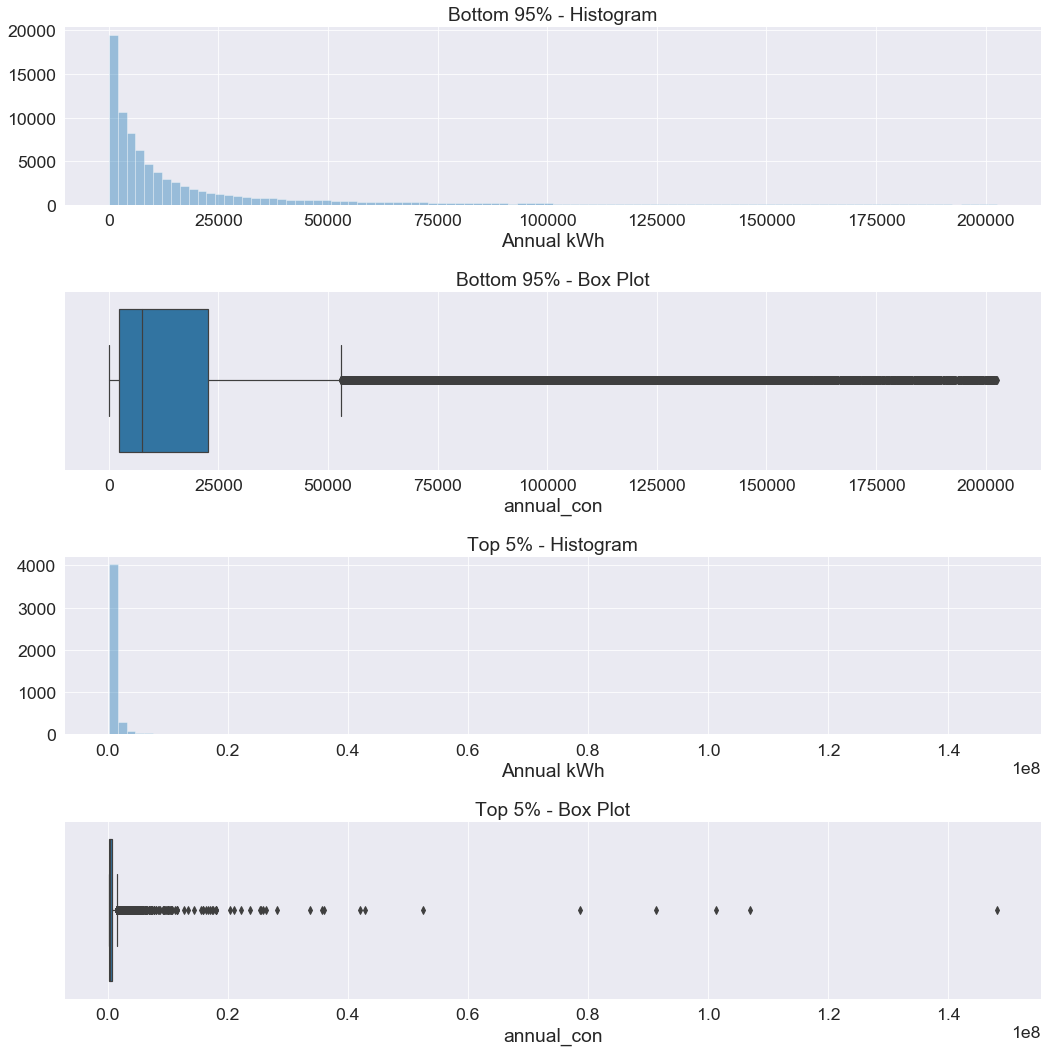

In [270]:
cutoff_pct = 0.95
cutoff = df_smud["annual_con"].quantile(cutoff_pct)
df_smud_clean=df_smud[df_smud["annual_con"]<=cutoff]
df_smud_outlier=df_smud[df_smud["annual_con"]>cutoff]
sns.set_context('paper',font_scale=2)
sns.set_style("darkgrid")
# plt.figure(figsize=(11, 16))
figure, axes = plt.subplots(nrows=4, figsize=(15, 15))

sns.distplot(df_smud_clean["annual_con"], ax=axes[0], 
             bins=100, axlabel="Annual kWh", norm_hist=False,  kde=False)
axes[0].set_title(f"Bottom {cutoff_pct:.0%} - Histogram")

sns.boxplot(df_smud_clean["annual_con"], ax=axes[1])
axes[1].set_title(f"Bottom {cutoff_pct:.0%} - Box Plot")

sns.distplot(df_smud_outlier["annual_con"], ax=axes[2], 
             bins=100, axlabel="Annual kWh", norm_hist=False, kde=False)
axes[2].set_title(f"Top {1-cutoff_pct:.0%} - Histogram")

sns.boxplot(df_smud_outlier["annual_con"], ax=axes[3])
axes[3].set_title(f"Top {1-cutoff_pct:.0%} - Box Plot")
plt.tight_layout()

In [271]:
df_smud['consumption_segment'] = df_smud[['annual_con']].apply(lambda x : pd.cut(x,[-1,2500,8300,28000,np.inf],
                                                       labels=["Q1", "Q2", "Q3", "Q4"]))
df_smud['consumption_segment'].value_counts()

Q2    22854
Q4    22721
Q3    22430
Q1    22318
Name: consumption_segment, dtype: int64

In [342]:
gb01 = df_smud.groupby(['name', 'consumption_segment'])
df_bldgs = gb01.agg({'building_id': pd.Series.nunique}).unstack()
df_bldgs['TOTAL'] = df_bldgs.sum(axis=1)
df_bldgs.sort_values('TOTAL', ascending=False, inplace=True)
df_bldgs.columns = ["Q1", "Q2", "Q3", "Q4", "TOTAL"]
df_bldgs.index.name = "activity_category"
# gb02 = df_smud.groupby(['name'])
# gb02.agg({'building_id': pd.Series.nunique})
# gb02 = df_smud.groupby(['consumption_segment'])
# gb02.agg({'building_id': pd.Series.nunique})

In [343]:
df_bldgs

,Q1,Q2,Q3,Q4,TOTAL
activity_category,,,,,
OFFICE,11292,8913,7055,5177,32437
RETAIL,1356,1730,2446,3247,8779
SERVICES,1684,2522,3167,1258,8631
WAREHOUSE_STORAGE,2116,1928,2109,1655,7808
FOOD_SALES_SERVICE,709,604,934,4386,6633
AGRICULTURE,1154,858,999,955,3966
UTILITY,444,2380,547,478,3849
HEALTHCARE,528,693,1348,1042,3611
MANUFACTURING_INDUSTRY,724,827,929,1097,3577


In [313]:
gb01 = df_smud.groupby(['activity_code', 'consumption_segment'])
df_bldgs_2 = gb01.agg({'building_id': pd.Series.nunique}).unstack()
df_bldgs_2['TOTAL'] = df_bldgs_2.sum(axis=1)
df_bldgs_2.sort_values('TOTAL', ascending=False, inplace=True)
df_bldgs_2.columns = ["Q1", "Q2", "Q3", "Q4", "TOTAL"]
df_bldgs_2.index.name = "activity_code"

# df_bldgs_2.reset_index(inplace=True)
# df_bldgs_2_filter = df_bldgs_2[(df_bldgs_2['activity_code']=='RESTAURANT') | (df_bldgs_2['activity_code']=='MOTEL_INN') | (df_bldgs_2['activity_code']=='HOTEL')]
# # df_bldgs_2['TOTAL'] = df_bldgs.sum(axis=1)
# df_bldgs_2_filter.set_index('activity_code')

# df_bldgs_2[df_bldgs_2.loc['RESTAURANT']]# | df_bldgs_2.loc['HOTEL']]

# df_bldgs_2.loc[
df_bldgs_2_filter = df_bldgs_2.loc[df_bldgs_2.index.isin(['RESTAURANT', 'HOTEL', 'MOTEL_INN'])]
df_bldgs_2_filter
# df_bldgs_2

,Q1,Q2,Q3,Q4,TOTAL
activity_code,,,,,
RESTAURANT,507.0,412.0,630.0,3134.0,4683.0
HOTEL,67.0,38.0,54.0,264.0,423.0
MOTEL_INN,NaN,1.0,1.0,3.0,5.0


| dbquery "FFSmud_FirstEngageTenant" "
SELECT a.building_id, b.label, activity_code, bac.name, aes.annual_con, aes.annual_cost 
FROM building b
JOIN building_usage bu
    ON bu.building_id = b.id
JOIN building_activities ba
    ON bu.primary_activity_id = ba.id
JOIN building_activity_categories bac
    ON ba.building_activity_categories_id = bac.id 
JOIN analysis a on a.building_id=b.id 
JOIN analysis_energy_stats aes on a.analysis_id=aes.analysis_id 
where energy_type_id=1"

| dbquery "FFSmud_FirstEngageTenant" "
SELECT activity_code, ecm_code, count(*)
FROM building b
JOIN building_usage bu
    ON bu.building_id = b.id
JOIN building_activities ba
    ON bu.primary_activity_id = ba.id
JOIN building_activity_categories bac
    ON ba.building_activity_categories_id = bac.id 
JOIN analysis a on a.building_id=b.id 
JOIN analysis_energy_stats aes on a.analysis_id=aes.analysis_id 
JOIN recommendation r ON a.analysis_id=r.analysis_id
join `smud_firstengage`.`recommendation_status` rs 
on r.id=rs.recommendation_id group by ecm_code" 
GROUP BY activity_code, ecm_code
where energy_type_id=1 and aes.annual_con>=8000 and aes.annual_con<=90000"

| dbxquery query="
SELECT ecm_code, count(*) 
FROM `smud_firstengage`.`recommendation` r 
join `smud_firstengage`.`recommendation_status` rs 
on r.id=rs.recommendation_id group by ecm_code" 
connection="FFSmud_FirstEngageTenant" limit=1000

In [314]:
base_ecm = "smud_ecm_quartile_Q"
df_smud_ecm = None
for i in range(1,5):
    df_input = pd.DataFrame.from_csv(dataf(base_ecm+str(i))+".csv")
    if df_smud_ecm is None:
        df_smud_ecm = df_input.copy()
    else:
        df_smud_ecm = df_smud_ecm.append(df_input)
    df_smud_ecm.shape


/Users/dcamell/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


(487, 3)

(1299, 3)

(2396, 3)

(4720, 3)

In [315]:
# df_smud_ecm.reset_index(inplace=True)
df_smud_ecm.info()
df_smud_ecm.describe()
df_smud_ecm.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4720 entries, AGRICULTURE to ZOO
Data columns (total 3 columns):
ecm_code    4720 non-null object
quartile    4720 non-null object
count(*)    4720 non-null int64
dtypes: int64(1), object(2)
memory usage: 147.5+ KB


,count(*)
count,4720.000000
mean,60.226059
std,210.008255
min,1.000000
25%,2.000000
50%,8.000000
75%,37.250000
max,4752.000000


,ecm_code,quartile,count(*)
activity_code,,,
AGRICULTURE,FEECM_DER_01,Q1,2
AGRICULTURE,FEECM_LTG_08,Q1,2
AUDITORIUM_THEATER,FEECM_HVC_06,Q1,8
AUDITORIUM_THEATER,FEECM_HVC_10,Q1,6
AUDITORIUM_THEATER,FEECM_HVC_11,Q1,4


In [316]:
df_smud_ecm.index.value_counts().head(10)

OTHER_OFFICE                 101
RESTAURANT                    97
OFFICE                        94
GOVERNMENT_OFFICE             93
OTHER_FOOD_SALES_SERVICE      84
SUPERMARKET_GROCERY_STORE     83
RETAIL_STORE                  81
OTHER_EDUCATION               80
FINANCIAL_OFFICE              79
OTHER_SERVICES                77
Name: activity_code, dtype: int64

In [317]:
category_lookup = df_smud[['name', 'activity_code']].drop_duplicates()
category_lookup.columns = ['activity_category', 'activity_code']
category_lookup.shape
category_lookup.head()
df_smud_ecm.shape
df_smud_ecm = pd.merge(df_smud_ecm, category_lookup, 
                       left_index=True, right_on='activity_code')
df_smud_ecm.shape
df_smud_ecm.head()

(123, 2)

,activity_category,activity_code
0,AGRICULTURE,AGRICULTURE
3883,AGRICULTURE,DAIRY_FARM
3901,AGRICULTURE,FRUIT_VEGETABLE_FARM
3902,AGRICULTURE,GRAIN_PRODUCTION
3903,AGRICULTURE,RANCH_MEAT_PRODUCTION


(4720, 3)

(4720, 5)

,ecm_code,quartile,count(*),activity_category,activity_code
0,FEECM_DER_01,Q1,2,AGRICULTURE,AGRICULTURE
0,FEECM_LTG_08,Q1,2,AGRICULTURE,AGRICULTURE
0,FEECM_DER_01,Q2,2,AGRICULTURE,AGRICULTURE
0,FEECM_HVC_01,Q2,1,AGRICULTURE,AGRICULTURE
0,FEECM_HVC_03,Q2,1,AGRICULTURE,AGRICULTURE


In [318]:
df_catalog = pd.DataFrame.from_csv(dataf("ecm_catalog.csv"))
df_smud_ecm.shape
df_smud_ecm = pd.merge(df_smud_ecm, df_catalog[['ecm_code','ecm_name']], on='ecm_code')
df_smud_ecm.shape
df_smud_ecm.head()

/Users/dcamell/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


(4720, 5)

(4720, 6)

,ecm_code,quartile,count(*),activity_category,activity_code,ecm_name
0,FEECM_DER_01,Q1,2,AGRICULTURE,AGRICULTURE,Reduce Peak Demand and Save with Battery Storage
1,FEECM_DER_01,Q2,2,AGRICULTURE,AGRICULTURE,Reduce Peak Demand and Save with Battery Storage
2,FEECM_DER_01,Q3,2,AGRICULTURE,AGRICULTURE,Reduce Peak Demand and Save with Battery Storage
3,FEECM_DER_01,Q4,28,AGRICULTURE,AGRICULTURE,Reduce Peak Demand and Save with Battery Storage
4,FEECM_DER_01,Q4,4,ENTERTAINMENT_AND_PUBLIC_ASSEMBLY,AUDITORIUM_THEATER,Reduce Peak Demand and Save with Battery Storage


In [319]:
# df_rest.head()
# df_rest = df_rest.groupby(['ecm_code', 'ecm_name','quartile']).sum()
# df_rest

In [320]:
df_rest = df_smud_ecm[df_smud_ecm['activity_code']=='RESTAURANT']
df_rest = df_rest.groupby(['ecm_code', 'ecm_name','quartile']).sum()
df_rest = df_rest.reset_index()#.set_index('ecm_code')
df_rest.info()
df_rest.head()
# df_lodg = df_smud_ecm[df_smud_ecm['activity_category']=='LODGING_RESIDENTIAL']
# df_lodg.info()
df_lodg = df_smud_ecm[(df_smud_ecm['activity_code']=='HOTEL') | (df_smud_ecm['activity_code']=='MOTEL_INN')]
df_lodg = df_lodg.groupby(['ecm_code', 'ecm_name','quartile']).sum()
df_lodg = df_lodg.reset_index()#.set_index('ecm_code')
# df_lodg.reset_index(inplace=True)
df_lodg.info()
df_lodg.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 4 columns):
ecm_code    97 non-null object
ecm_name    97 non-null object
quartile    97 non-null object
count(*)    97 non-null int64
dtypes: int64(1), object(3)
memory usage: 3.1+ KB


,ecm_code,ecm_name,quartile,count(*)
0,FEECM_DER_01,Reduce Peak Demand and Save with Battery Storage,Q1,1
1,FEECM_DER_01,Reduce Peak Demand and Save with Battery Storage,Q4,103
2,FEECM_FSG_01,Install kitchen hood controls,Q4,1599
3,FEECM_FSG_02,Install refrigeration controls,Q4,292
4,FEECM_FSG_03,Use night blinds or covers on open refrigerati...,Q4,758


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
ecm_code    48 non-null object
ecm_name    48 non-null object
quartile    48 non-null object
count(*)    48 non-null int64
dtypes: int64(1), object(3)
memory usage: 1.6+ KB


,ecm_code,ecm_name,quartile,count(*)
0,FEECM_DER_01,Reduce Peak Demand and Save with Battery Storage,Q4,30
1,FEECM_FSG_02,Install refrigeration controls,Q4,106
2,FEECM_FSG_07,Choose efficient dishwashers,Q4,189
3,FEECM_FSG_17,Use efficient electric commercial ovens,Q4,4
4,FEECM_FSG_18,"Use efficient electric fryers, griddles, and s...",Q4,4


In [321]:
df_rest.sort_values('count(*)', inplace=True, ascending=False)
top_rest_ecms = df_rest.groupby('ecm_code').sum().sort_values('count(*)', 
                                                              ascending=False).iloc[0:10]
top_rest_ecms


,count(*)
ecm_code,
FEECM_HVC_08,3273
FEECM_MSC_12,2852
FEECM_HVC_02,2722
FEECM_HVC_20,2349
FEECM_FSG_07,1740
FEECM_LTG_06,1725
FEECM_HVC_06,1675
FEECM_FSG_01,1599
FEECM_FSG_04,1183


In [322]:
top_rest_ecm_codes = list(top_rest_ecms.index.values)

Text(0.5,1,'Restaurant Top 10 ECMs')

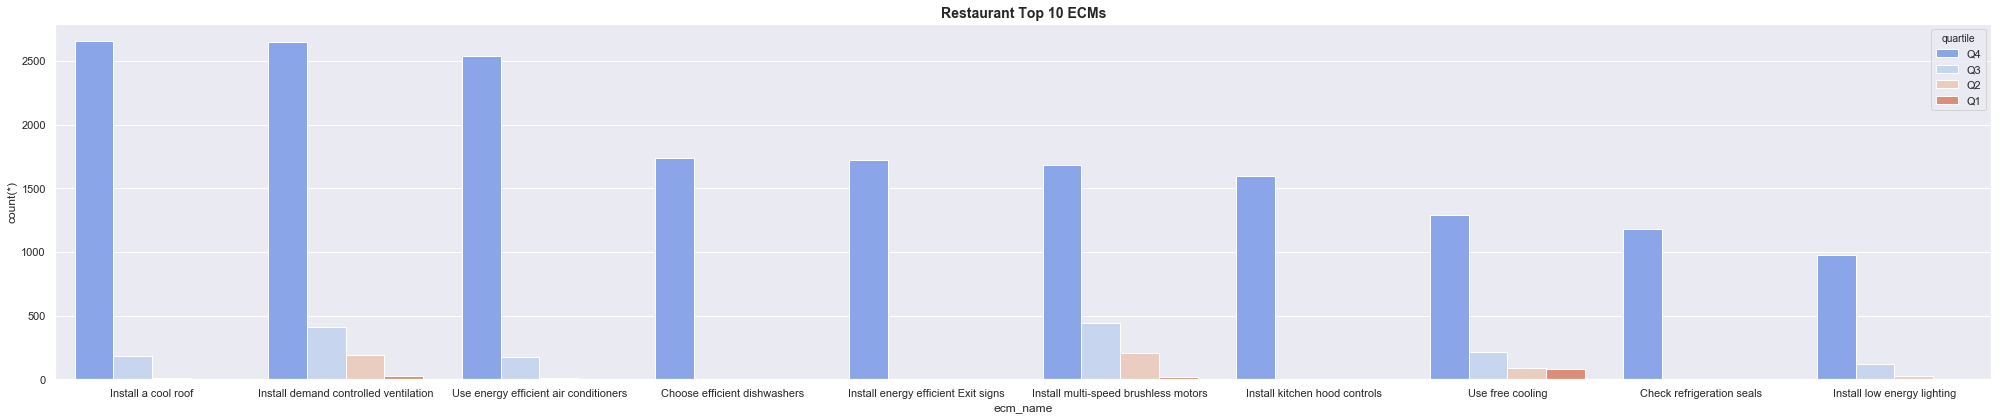

In [323]:
df_rest_top = df_rest[df_rest['ecm_code'].isin(top_rest_ecm_codes)]
sns.set_context('notebook',font_scale=1)
sns.set_style("darkgrid")
plt.figure(figsize=(28, 6))

ax = plt.axes()
sns.barplot(x='ecm_name', y='count(*)',
            hue='quartile',data=df_rest_top,
            palette='coolwarm', ax=ax)
ax.set_title("Restaurant Top 10 ECMs",
             {'fontsize':14,
             'fontweight':'bold'})
plt.tight_layout()

Q1    0.473373
Q2    2.145631
Q3    3.558730
Q4    9.787811
dtype: float64

pandas.core.series.Series

Text(0.5,1,'Restaurant ECM per Building')

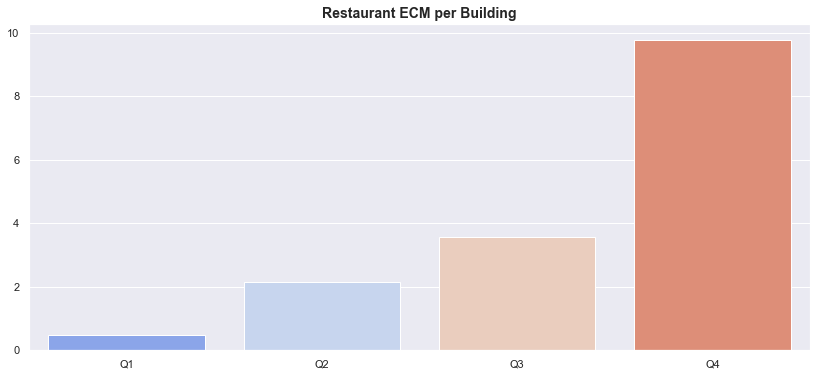

In [324]:
rest_ecm_counts = df_rest.groupby('quartile').sum()['count(*)']
rest_bldg_counts = df_smud[df_smud['activity_code']=='RESTAURANT']['consumption_segment'].value_counts()
ecm_per_rest = rest_ecm_counts/rest_bldg_counts
ecm_per_rest
type(ecm_per_rest)

sns.set_context('notebook',font_scale=1)
sns.set_style("darkgrid")
plt.figure(figsize=(14, 6))
ax = plt.axes()
sns.barplot(ecm_per_rest.index, ecm_per_rest.values, palette='coolwarm', ax=ax)
ax.set_title("Restaurant ECM per Building",
             {'fontsize':14,
             'fontweight':'bold'})

In [325]:
df_lodg.sort_values('count(*)', inplace=True, ascending=False)
top_lodg_ecms = df_lodg.groupby('ecm_code').sum().sort_values('count(*)', 
                                                              ascending=False).iloc[0:10]
top_lodg_ecms

,count(*)
ecm_code,
FEECM_HVC_24,313
FEECM_HVC_08,286
FEECM_MSC_12,242
FEECM_MSC_04,238
FEECM_HVC_23,234
FEECM_HVC_02,233
FEECM_FSG_07,189
FEECM_LTG_06,187
FEECM_HVC_20,155


In [326]:
top_lodg_ecm_codes = list(top_lodg_ecms.index.values)
top_lodg_ecm_codes

['FEECM_HVC_24',
 'FEECM_HVC_08',
 'FEECM_MSC_12',
 'FEECM_MSC_04',
 'FEECM_HVC_23',
 'FEECM_HVC_02',
 'FEECM_FSG_07',
 'FEECM_LTG_06',
 'FEECM_HVC_20',
 'FEECM_FSG_02']

Text(0.5,1,'Hotel/Motel Top 10 ECMs')

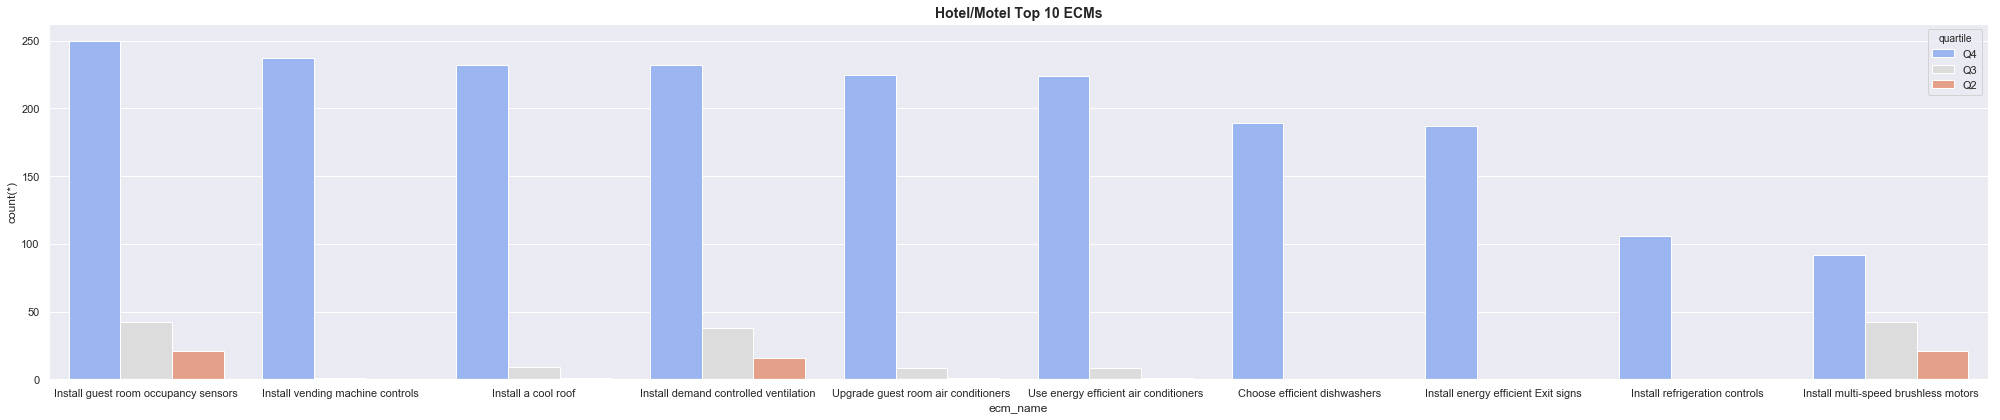

In [327]:
df_lodg_top = df_lodg[df_lodg['ecm_code'].isin(top_lodg_ecm_codes)]
sns.set_context('notebook',font_scale=1)
sns.set_style("darkgrid")
plt.figure(figsize=(28, 6))

ax = plt.axes()
sns.barplot(x='ecm_name', y='count(*)', ci=None,
            hue='quartile',data=df_lodg_top,
            palette='coolwarm', ax=ax)
ax.set_title("Hotel/Motel Top 10 ECMs",
             {'fontsize':14,
             'fontweight':'bold'})
plt.tight_layout()

In [328]:
df_lodg_top['ecm_name'].value_counts()

Install guest room occupancy sensors     3
Use energy efficient air conditioners    3
Install demand controlled ventilation    3
Install a cool roof                      3
Upgrade guest room air conditioners      3
Install multi-speed brushless motors     3
Install vending machine controls         2
Choose efficient dishwashers             1
Install refrigeration controls           1
Install energy efficient Exit signs      1
Name: ecm_name, dtype: int64

In [329]:
df_lodg_top['ecm_code'].value_counts()

FEECM_HVC_23    3
FEECM_HVC_02    3
FEECM_HVC_24    3
FEECM_HVC_20    3
FEECM_HVC_08    3
FEECM_MSC_12    3
FEECM_MSC_04    2
FEECM_FSG_02    1
FEECM_FSG_07    1
FEECM_LTG_06    1
Name: ecm_code, dtype: int64

In [330]:
df_lodg_top[df_lodg_top['ecm_code']=="FEECM_HVC_24"]

,ecm_code,ecm_name,quartile,count(*)
35,FEECM_HVC_24,Install guest room occupancy sensors,Q4,250
34,FEECM_HVC_24,Install guest room occupancy sensors,Q3,42
33,FEECM_HVC_24,Install guest room occupancy sensors,Q2,21


Text(0.5,1,'Hotel/Motel ECM per Building')

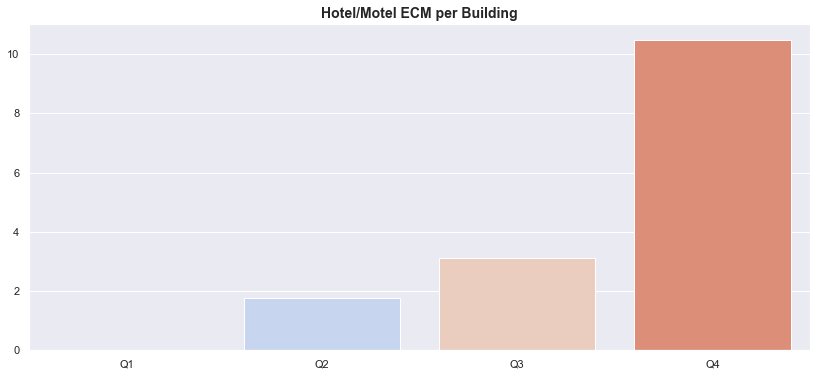

In [331]:
lodg_ecm_counts = df_lodg.groupby('quartile').sum()['count(*)']
lodg_bldg_counts = df_smud[df_smud['activity_code']=='HOTEL']['consumption_segment'].value_counts()
lodg_bldg_counts += df_smud[df_smud['activity_code']=='MOTEL_INN']['consumption_segment'].value_counts()

ecm_per_hotel = lodg_ecm_counts/lodg_bldg_counts

sns.set_context('notebook',font_scale=1)
sns.set_style("darkgrid")
plt.figure(figsize=(14, 6))
ax = plt.axes()
sns.barplot(ecm_per_hotel.index, ecm_per_hotel.values, palette='coolwarm', ax=ax)
ax.set_title("Hotel/Motel ECM per Building",
             {'fontsize':14,
             'fontweight':'bold'})

,Q1,Q2,Q3,Q4,TOTAL
activity_code,,,,,
RESTAURANT,507.0,412.0,630.0,3134.0,4683.0
HOTEL,67.0,38.0,54.0,264.0,423.0
MOTEL_INN,NaN,1.0,1.0,3.0,5.0


,activity_code,consumption_segment,count
0,RESTAURANT,Q1,507.0
1,RESTAURANT,Q2,412.0
2,RESTAURANT,Q3,630.0
3,RESTAURANT,Q4,3134.0
4,HOTEL,Q1,67.0
5,HOTEL,Q2,38.0
6,HOTEL,Q3,54.0
7,HOTEL,Q4,264.0


Text(0.5,1,'HOTEL: How Many Buildings?')

Text(0.5,1,'RESTAURANT: How Many Buildings?')

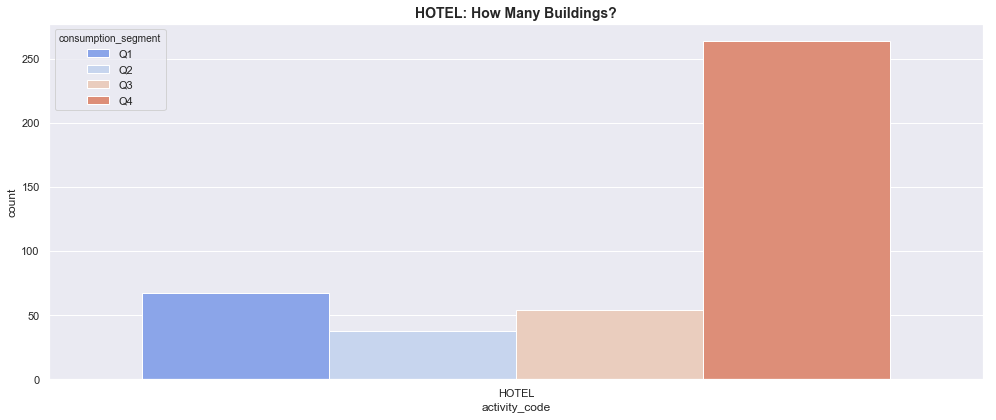

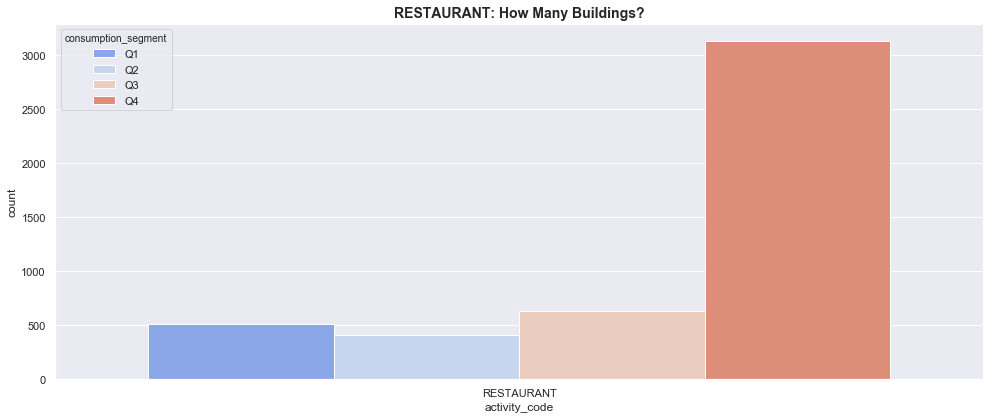

In [334]:
try:
    df_bldgs_2_filter.set_index('activity_code', inplace=True)
except KeyError:
    pass
df_bldgs_2_filter
df_plot_rest_hotel_total = df_bldgs_2_filter.drop('TOTAL', axis=1)
df_plot_rest_hotel_total = df_plot_rest_hotel_total.drop('MOTEL_INN', axis=0)
# df_plot_rest_hotel_total.reset_index(inplace=True)
df_plot_rest_hotel_total =df_plot_rest_hotel_total.stack().reset_index()
df_plot_rest_hotel_total.columns = ['activity_code', 'consumption_segment', 'count']
df_plot_rest_hotel_total
for x in set(df_plot_rest_hotel_total['activity_code']):
    temp_plot = df_plot_rest_hotel_total[df_plot_rest_hotel_total['activity_code']==x]
    sns.set_context('notebook',font_scale=1)
    sns.set_style("darkgrid")
    plt.figure(figsize=(14, 6))
    ax = plt.axes()
    sns.barplot(x='activity_code', y='count',
                hue='consumption_segment',data=temp_plot,
                palette='coolwarm', ax=ax)
    ax.set_title(f"{x}: How Many Buildings?",
                 {'fontsize':14,
                 'fontweight':'bold'})
    plt.tight_layout()


In [336]:
# list(df_plot_rest_hotel_total.columns.get_level_values(1))

In [337]:
set(df_plot_rest_hotel_total['activity_code'])

{'HOTEL', 'RESTAURANT'}

In [362]:
# (df_bldgs/df_bldgs.sum()).style.format({('building_id','Q1'): "{:.1%}",
#                                         ('building_id','Q2'): "{:.1%}",
#                                         ('building_id','Q3'): "{:.1%}",
#                                         ('building_id','Q4'): "{:.2%}",
#                                         ('TOTAL',''): "{:.2%}"})


df_bldg_pct = df_bldgs/df_bldgs.sum()
df_bldg_pct['CUMSUM'] = df_bldg_pct['TOTAL'].cumsum()

pct_format = {x:"{:.1%}" for x in df_bldg_pct.columns}
dbp_cutoff = df_bldg_pct.shift(periods=1)['CUMSUM']<=0.8
dbp_cutoff[0] = True
df_bldg_pct_cut = df_bldg_pct[dbp_cutoff]
df_bldg_pct_cut.style.format(pct_format)




,Q1,Q2,Q3,Q4,TOTAL,CUMSUM
activity_category,,,,,,
OFFICE,50.6%,39.0%,31.5%,22.8%,35.9%,35.9%
RETAIL,6.1%,7.6%,10.9%,14.3%,9.7%,45.6%
SERVICES,7.5%,11.0%,14.1%,5.5%,9.6%,55.2%
WAREHOUSE_STORAGE,9.5%,8.4%,9.4%,7.3%,8.6%,63.8%
FOOD_SALES_SERVICE,3.2%,2.6%,4.2%,19.3%,7.3%,71.2%
AGRICULTURE,5.2%,3.8%,4.5%,4.2%,4.4%,75.6%
UTILITY,2.0%,10.4%,2.4%,2.1%,4.3%,79.8%
HEALTHCARE,2.4%,3.0%,6.0%,4.6%,4.0%,83.8%


In [372]:
df_bldg_copy = df_bldgs.copy() # /df_bldgs.sum()
df_bldg_copy['CUMSUM'] = df_bldg_copy['TOTAL'].cumsum()

# pct_format = {x:"{:.1%}" for x in df_bldg_pct.columns}
# dbp_cutoff = df_bldg_pct.shift(periods=1)['CUMSUM']<=0.8
# dbp_cutoff[0] = True
# df_bldg_pct_cut = df_bldg_pct[dbp_cutoff]
df_bldg_copy #.style.format() #pct_format)

,Q1,Q2,Q3,Q4,TOTAL,CUMSUM
activity_category,,,,,,
OFFICE,11292,8913,7055,5177,32437,32437
RETAIL,1356,1730,2446,3247,8779,41216
SERVICES,1684,2522,3167,1258,8631,49847
WAREHOUSE_STORAGE,2116,1928,2109,1655,7808,57655
FOOD_SALES_SERVICE,709,604,934,4386,6633,64288
AGRICULTURE,1154,858,999,955,3966,68254
UTILITY,444,2380,547,478,3849,72103
HEALTHCARE,528,693,1348,1042,3611,75714
MANUFACTURING_INDUSTRY,724,827,929,1097,3577,79291


In [367]:
pareto_val = 0.8

df_bldgs_2_pct = df_bldgs_2/df_bldgs_2.sum()
df_bldgs_2_pct['CUMSUM'] = df_bldgs_2_pct['TOTAL'].cumsum()

pct_format_2 = {x:"{:.1%}" for x in df_bldgs_2_pct.columns}
dbp2_cutoff = df_bldgs_2_pct.shift(periods=1)['CUMSUM']<=pareto_val
dbp2_cutoff[0] = True
df_bldgs_2_pct_cut = df_bldgs_2_pct[dbp2_cutoff]

f"{len(df_bldgs_2_pct_cut) / len(df_bldgs_2_pct):.1%} primary activities cover {pareto_val:.1%} of buildings"

df_bldgs_2_pct_cut.style.format(pct_format_2)
                                
#TODO : maybe get line by line stats?

# df_bldgs_2_pct_drop = df_bldgs_2_pct[~dbp2_cutoff]
# df_bldgs_2_pct_drop.style.format(pct_format_2)

# df_bldgs_2_pct_cut = df_bldgs_2_pct[df_bldgs_2_pct.shift(periods=1)['CUMSUM']<=0.8]
# df_bldgs_2_pct_cut.style.format(pct_format_2)

'13.8% primary activities cover 80.0% of buildings'

,Q1,Q2,Q3,Q4,TOTAL,CUMSUM
activity_code,,,,,,
OTHER_OFFICE,40.7%,32.3%,24.4%,16.0%,28.3%,28.3%
WAREHOUSE_NON_REFRIGERATED,7.9%,6.8%,6.7%,4.7%,6.5%,34.8%
RETAIL_STORE,3.9%,5.2%,7.3%,9.1%,6.4%,41.2%
RESTAURANT,2.3%,1.8%,2.8%,13.8%,5.2%,46.4%
OFFICE,5.3%,4.3%,4.8%,3.5%,4.5%,50.9%
AGRICULTURE,5.0%,3.7%,4.4%,4.1%,4.3%,55.2%
MANUFACTURING_INDUSTRIAL_PLANT,3.1%,3.5%,4.1%,4.6%,3.8%,59.0%
VEHICLE_REPAIR_SHOP,2.5%,3.7%,4.0%,1.8%,3.0%,62.0%
OTHER_SERVICES,2.9%,2.9%,3.4%,1.6%,2.7%,64.7%


In [346]:
df_bldgs

,Q1,Q2,Q3,Q4,TOTAL
activity_category,,,,,
OFFICE,11292,8913,7055,5177,32437
RETAIL,1356,1730,2446,3247,8779
SERVICES,1684,2522,3167,1258,8631
WAREHOUSE_STORAGE,2116,1928,2109,1655,7808
FOOD_SALES_SERVICE,709,604,934,4386,6633
AGRICULTURE,1154,858,999,955,3966
UTILITY,444,2380,547,478,3849
HEALTHCARE,528,693,1348,1042,3611
MANUFACTURING_INDUSTRY,724,827,929,1097,3577


In [ ]:
[x for x in df_bldgs.columns]

In [375]:
df_bldgs_2

,Q1,Q2,Q3,Q4,TOTAL
activity_code,,,,,
OTHER_OFFICE,9092.0,7384.0,5478.0,3632.0,25586.0
WAREHOUSE_NON_REFRIGERATED,1769.0,1554.0,1502.0,1057.0,5882.0
RETAIL_STORE,869.0,1178.0,1633.0,2064.0,5744.0
RESTAURANT,507.0,412.0,630.0,3134.0,4683.0
OFFICE,1194.0,990.0,1074.0,786.0,4044.0
AGRICULTURE,1119.0,845.0,982.0,937.0,3883.0
MANUFACTURING_INDUSTRIAL_PLANT,703.0,803.0,916.0,1055.0,3477.0
VEHICLE_REPAIR_SHOP,550.0,854.0,899.0,420.0,2723.0
OTHER_SERVICES,645.0,666.0,764.0,360.0,2435.0


In [376]:
df_smud_ecm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4720 entries, 0 to 4719
Data columns (total 6 columns):
ecm_code             4720 non-null object
quartile             4720 non-null object
count(*)             4720 non-null int64
activity_category    4720 non-null object
activity_code        4720 non-null object
ecm_name             4720 non-null object
dtypes: int64(1), object(5)
memory usage: 258.1+ KB


In [377]:
df_smud_ecm.head()

,ecm_code,quartile,count(*),activity_category,activity_code,ecm_name
0,FEECM_DER_01,Q1,2,AGRICULTURE,AGRICULTURE,Reduce Peak Demand and Save with Battery Storage
1,FEECM_DER_01,Q2,2,AGRICULTURE,AGRICULTURE,Reduce Peak Demand and Save with Battery Storage
2,FEECM_DER_01,Q3,2,AGRICULTURE,AGRICULTURE,Reduce Peak Demand and Save with Battery Storage
3,FEECM_DER_01,Q4,28,AGRICULTURE,AGRICULTURE,Reduce Peak Demand and Save with Battery Storage
4,FEECM_DER_01,Q4,4,ENTERTAINMENT_AND_PUBLIC_ASSEMBLY,AUDITORIUM_THEATER,Reduce Peak Demand and Save with Battery Storage


In [378]:
df_smud_ecm.groupby("activity_category").agg({'count(*)':'sum'}).

,count(*)
activity_category,
AGRICULTURE,3204
BANKING,8442
EDUCATION,13452
ENTERTAINMENT_AND_PUBLIC_ASSEMBLY,8460
FOOD_SALES_SERVICE,52088


In [483]:
df_smud_ecm_consumption

,count,q_low,q_med,q_high,ecm_low,ecm_med,ecm_high,pct_of_total,cumulative_pct
activity_code,,,,,,,,,
OTHER_OFFICE,18893,2.537696e+03,6.742879e+03,1.865473e+04,1.000000,2.095554,5.000000,0.292928,0.292928
RETAIL_STORE,4335,9.312421e+03,2.251651e+04,5.484839e+04,2.000000,3.876525,6.000000,0.067212,0.360141
WAREHOUSE_NON_REFRIGERATED,3979,3.851878e+03,9.931849e+03,2.611191e+04,1.000000,3.000000,4.013743,0.061693,0.421834
RESTAURANT,3743,2.966276e+04,6.100975e+04,1.127008e+05,5.000000,7.817311,13.043537,0.058034,0.479867
OFFICE,2779,4.607161e+03,1.123294e+04,2.972295e+04,2.055781,4.000000,7.000000,0.043087,0.522955
MANUFACTURING_INDUSTRIAL_PLANT,2761,4.701850e+03,1.355522e+04,4.294572e+04,2.000000,3.000000,4.000000,0.042808,0.565763
MEDICAL_OFFICE,1860,7.630194e+03,1.460002e+04,2.736401e+04,2.000000,3.000000,5.000000,0.028839,0.594601
VEHICLE_REPAIR_SHOP,1823,6.319370e+03,1.193545e+04,2.363068e+04,1.000000,2.000000,3.076923,0.028265,0.622866
BEAUTY_BARBER_SHOP,1776,6.328991e+03,1.033681e+04,1.669999e+04,2.000000,2.000000,4.000000,0.027536,0.650402


In [381]:
df_smud_ecm_consumption = pd.read_csv(dataf("smud_ecm&consumption.csv"))

| dbxquery query="SELECT ecm_code, ba.activity_code, count(*) ecm_instances
FROM recommendation r 
JOIN analysis a ON a.analysis_id = r.analysis_id
JOIN building b on b.id=a.building_id
JOIN building_usage bu on bu.building_id = b.id
JOIN building_activities ba on ba.id=bu.primary_activity_id
GROUP BY ecm_code, activity_code
ORDER BY activity_code, ecm_frequency DESC" connection="FFSmud_FirstEngageTenant"

In [463]:
df_top_ecm_by_pa = pd.read_csv(dataf("top_ecm_by_pa.csv"))

In [428]:
df_smud_ecm_consumption.sort_values('count', inplace=True, ascending=False)
df_smud_ecm_consumption['pct_of_total'] = df_smud_ecm_consumption['count'] / df_smud_ecm_consumption['count'].sum()
df_smud_ecm_consumption['cumulative_pct'] = df_smud_ecm_consumption['pct_of_total'].cumsum()
df_smud_ecm_consumption.set_index("activity_code", inplace=True)
df_smud_ecm_consumption.head(20)

,count,q_low,q_med,q_high,ecm_low,ecm_med,ecm_high,pct_of_total,cumulative_pct
activity_code,,,,,,,,,
OTHER_OFFICE,18893,2537.695790,6742.878570,18654.727355,1.000000,2.095554,5.000000,0.292928,0.292928
RETAIL_STORE,4335,9312.420894,22516.510346,54848.386495,2.000000,3.876525,6.000000,0.067212,0.360141
WAREHOUSE_NON_REFRIGERATED,3979,3851.877816,9931.849449,26111.912583,1.000000,3.000000,4.013743,0.061693,0.421834
RESTAURANT,3743,29662.760570,61009.752177,112700.817592,5.000000,7.817311,13.043537,0.058034,0.479867
OFFICE,2779,4607.161437,11232.942477,29722.946813,2.055781,4.000000,7.000000,0.043087,0.522955
MANUFACTURING_INDUSTRIAL_PLANT,2761,4701.849641,13555.217059,42945.717761,2.000000,3.000000,4.000000,0.042808,0.565763
MEDICAL_OFFICE,1860,7630.193875,14600.024066,27364.010646,2.000000,3.000000,5.000000,0.028839,0.594601
VEHICLE_REPAIR_SHOP,1823,6319.370005,11935.452378,23630.681992,1.000000,2.000000,3.076923,0.028265,0.622866
BEAUTY_BARBER_SHOP,1776,6328.990959,10336.812443,16699.990253,2.000000,2.000000,4.000000,0.027536,0.650402


In [432]:
# row_cut = 
(df_smud_ecm_consumption.cumulative_pct>0.8).idxmax()
# df_smud_ecm_consumption.iloc[0:row_cut]

'FINANCIAL_OFFICE'

In [464]:
df_top_ecm_by_pa.head(20)

,activity_code,ecm_code,ecm_instances
0,ADULT_EDUCATION,FEECM_HVC_09,1
1,ADULT_EDUCATION,FEECM_LTG_01,1
2,ADULT_EDUCATION,FEECM_HVC_11,1
3,ADULT_EDUCATION,FEECM_HVC_10,1
4,ADULT_EDUCATION,FEECM_LTG_08,1
5,AGRICULTURE,FEECM_AGR_03,1033
6,AGRICULTURE,FEECM_AGR_02,1033
7,AGRICULTURE,FEECM_LTG_08,510
8,AGRICULTURE,FEECM_AGR_10,250
9,AGRICULTURE,FEECM_AGR_04,166


In [492]:
rank_mask = df_top_ecm_by_pa.groupby('activity_code').rank(ascending=False, method='first').ecm_instances
df_top_ecm_by_pa['ecm_rank'] = rank_mask
df_top_3_ecm_by_pa = df_top_ecm_by_pa.loc[df_top_ecm_by_pa['ecm_rank']<=3]
df_top_3_ecm_by_pa = df_top_3_ecm_by_pa.set_index(['activity_code',
                                                   'ecm_rank']).unstack()
df_top_3_ecm_by_pa.head(20)

ecm_code                              \
ecm_rank                                   1             2             3   
activity_code                                                              
ADULT_EDUCATION                 FEECM_HVC_09  FEECM_LTG_01  FEECM_HVC_11   
AGRICULTURE                     FEECM_AGR_03  FEECM_AGR_02  FEECM_LTG_08   
AIRPLANE_HANGAR                 FEECM_HVC_20  FEECM_LTG_01  FEECM_HVC_05   
AUDITORIUM_THEATER              FEECM_HVC_08  FEECM_HVC_20  FEECM_MSC_12   
AUTOMOBILE_DEALERSHIP           FEECM_HVC_09  FEECM_HVC_20  FEECM_LTG_01   
BANK_BRANCH                     FEECM_DER_01  FEECM_HVC_08  FEECM_HVC_20   
BAR_NIGHTCLUB                   FEECM_HVC_08  FEECM_MSC_12  FEECM_HVC_20   
BEAUTY_BARBER_SHOP              FEECM_HVC_20  FEECM_HVC_09  FEECM_HVC_03   
BEER_LIQUOR_STORE               FEECM_MSC_12  FEECM_HVC_02  FEECM_HVC_20   
BOWLING_ALLEY                   FEECM_HVC_08  FEECM_LTG_06  FEECM_DER_01   
BROADCASTING_STUDIO             FEECM_DER_01  FEECM_HVC_08  FEECM_HVC_20   
CALL_CENTER                     FEECM_HVC_08  FEECM_HVC_09  FEECM_HVC_20   
CAR_WASH                        FEECM_LTG_01  FEECM_HVC_20  FEECM_MSC_12   
CASINO                          FEECM_DER_01  FEECM_HVC_08  FEECM_MSC_12   
CATERING_RECEPTION_HALL         FEECM_HVC_08  FEECM_HVC_20  FEECM_HVC_02   
CITY_HALL_CITY_CENTER           FEECM_HVC_09          None          None   
COFFEE_DOUGHNUT_SHOP            FEECM_HVC_20  FEECM_HVC_06  FEECM_HVC_02   
COLLEGE_UNIVERSITY              FEECM_MSC_04  FEECM_HVC_08  FEECM_HVC_09   
CONTRACTOR_OFFICE               FEECM_HVC_20  FEECM_HVC_08  FEECM_HVC_09   
CONV_STORE_WITHOUT_GAS_STATION  FEECM_MSC_12  FEECM_HVC_02  FEECM_HVC_20   

                               ecm_instances                 
ecm_rank                                   1       2      3  
activity_code                                                
ADULT_EDUCATION                          1.0     1.0    1.0  
AGRICULTURE                           1033.0  1033.0  510.0  
AIRPLANE_HANGAR                          3.0     2.0    2.0  
AUDITORIUM_THEATER                      83.0    77.0   45.0  
AUTOMOBILE_DEALERSHIP                  661.0   605.0  342.0  
BANK_BRANCH                            648.0   490.0  454.0  
BAR_NIGHTCLUB                          194.0   169.0  167.0  
BEAUTY_BARBER_SHOP                    1589.0  1363.0  350.0  
BEER_LIQUOR_STORE                      170.0   168.0  161.0  
BOWLING_ALLEY                            1.0     1.0    1.0  
BROADCASTING_STUDIO                      8.0     7.0    6.0  
CALL_CENTER                             14.0    12.0   11.0  
CAR_WASH                                72.0    41.0   31.0  
CASINO                                  19.0    17.0   12.0  
CATERING_RECEPTION_HALL                 38.0    34.0   26.0  
CITY_HALL_CITY_CENTER                    1.0     NaN    NaN  
COFFEE_DOUGHNUT_SHOP                     7.0     5.0    5.0  
COLLEGE_UNIVERSITY                      66.0    64.0   61.0  
CONTRACTOR_OFFICE                       52.0    45.0   34.0  
CONV_STORE_WITHOUT_GAS_STATION         121.0   112.0  111.0

In [493]:
df_smud_ecm_consumption.index
df_top_3_ecm_by_pa.index

Index(['OTHER_OFFICE', 'RETAIL_STORE', 'WAREHOUSE_NON_REFRIGERATED',
       'RESTAURANT', 'OFFICE', 'MANUFACTURING_INDUSTRIAL_PLANT',
       'MEDICAL_OFFICE', 'VEHICLE_REPAIR_SHOP', 'BEAUTY_BARBER_SHOP',
       'OTHER_SERVICES',
       ...
       'PLASTICS_FABRICATION', 'PERSONAL_SERVICES', 'HIGH_SCHOOL',
       'DINING_FACILITY', 'TANNING_SALON', 'CITY_HALL_CITY_CENTER',
       'TRAINING_FACILITY', 'SOCIAL_MEETING_HALL', 'RETIREMENT_HOME',
       'ADULT_EDUCATION'],
      dtype='object', name='activity_code', length=119)

Index(['ADULT_EDUCATION', 'AGRICULTURE', 'AIRPLANE_HANGAR',
       'AUDITORIUM_THEATER', 'AUTOMOBILE_DEALERSHIP', 'BANK_BRANCH',
       'BAR_NIGHTCLUB', 'BEAUTY_BARBER_SHOP', 'BEER_LIQUOR_STORE',
       'BOWLING_ALLEY',
       ...
       'VEHICLE_REPAIR_SHOP', 'VETERINARY_OFFICE', 'VINEYARD_WINERY',
       'VOCATIONAL', 'WAREHOUSE_NON_REFRIGERATED', 'WAREHOUSE_REFRIGERATED',
       'WASTEWATER_TREATMENT_PLANT', 'WHOLESALE_CLUB_SUPERCENTER',
       'WORSHIP_FACILITY', 'ZOO'],
      dtype='object', name='activity_code', length=119)

/Users/dcamell/miniconda/envs/py36/lib/python3.6/site-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,count,q_low,q_med,q_high,ecm_low,ecm_med,ecm_high,pct_of_total,cumulative_pct,"(ecm_code, 1)","(ecm_code, 2)","(ecm_code, 3)","(ecm_instances, 1)","(ecm_instances, 2)","(ecm_instances, 3)"
activity_code,,,,,,,,,,,,,,,
BEAUTY_BARBER_SHOP,1776,6328.990959,10336.812443,16699.990253,2.00,2.000000,4.00,0.027536,0.650402,FEECM_HVC_20,FEECM_HVC_09,FEECM_HVC_03,1589.0,1363.0,350.0
AGRICULTURE,1179,22550.909976,37826.647513,81079.960897,2.00,2.000000,3.00,0.018280,0.774501,FEECM_AGR_03,FEECM_AGR_02,FEECM_LTG_08,1033.0,1033.0,510.0
AUTOMOBILE_DEALERSHIP,973,6559.251279,15808.113947,45049.829071,2.00,3.000000,5.00,0.015086,0.789587,FEECM_HVC_09,FEECM_HVC_20,FEECM_LTG_01,661.0,605.0,342.0
BANK_BRANCH,651,8127.769281,21620.383185,63746.649118,4.00,6.947692,9.00,0.010093,0.843915,FEECM_DER_01,FEECM_HVC_08,FEECM_HVC_20,648.0,490.0,454.0
BAR_NIGHTCLUB,214,27909.498032,45856.337240,68756.759622,5.00,7.000000,10.00,0.003318,0.947951,FEECM_HVC_08,FEECM_MSC_12,FEECM_HVC_20,194.0,169.0,167.0
BEER_LIQUOR_STORE,199,40624.543750,67468.881944,88363.243327,5.00,7.444444,16.00,0.003085,0.951036,FEECM_MSC_12,FEECM_HVC_02,FEECM_HVC_20,170.0,168.0,161.0
CONV_STORE_WITHOUT_GAS_STATION,172,21468.453267,63312.293403,127812.064583,4.00,6.000000,12.00,0.002667,0.956649,FEECM_MSC_12,FEECM_HVC_02,FEECM_HVC_20,121.0,112.0,111.0
CAR_WASH,114,10091.453657,20168.892357,46387.685539,1.00,2.000000,4.00,0.001768,0.973224,FEECM_LTG_01,FEECM_HVC_20,FEECM_MSC_12,72.0,41.0,31.0
AUDITORIUM_THEATER,109,5129.000000,11926.289714,47686.600000,3.00,4.250000,6.00,0.001690,0.974914,FEECM_HVC_08,FEECM_HVC_20,FEECM_MSC_12,83.0,77.0,45.0


ecm_rank,1,2,3
activity_code,,,
ADULT_EDUCATION,1.0,1.0,1.0
AGRICULTURE,1033.0,1033.0,510.0
AIRPLANE_HANGAR,3.0,2.0,2.0
AUDITORIUM_THEATER,83.0,77.0,45.0
AUTOMOBILE_DEALERSHIP,661.0,605.0,342.0
BANK_BRANCH,648.0,490.0,454.0
BAR_NIGHTCLUB,194.0,169.0,167.0
BEAUTY_BARBER_SHOP,1589.0,1363.0,350.0
BEER_LIQUOR_STORE,170.0,168.0,161.0


activity_code
OTHER_OFFICE                           18893
RETAIL_STORE                            4335
WAREHOUSE_NON_REFRIGERATED              3979
RESTAURANT                              3743
OFFICE                                  2779
MANUFACTURING_INDUSTRIAL_PLANT          2761
MEDICAL_OFFICE                          1860
VEHICLE_REPAIR_SHOP                     1823
BEAUTY_BARBER_SHOP                      1776
OTHER_SERVICES                          1572
OTHER_UTILITY                           1356
GOVERNMENT_OFFICE                       1335
WAREHOUSE_REFRIGERATED                  1286
WORSHIP_FACILITY                        1276
AGRICULTURE                             1179
AUTOMOBILE_DEALERSHIP                    973
FINANCIAL_OFFICE                         749
RECREATION_COMMUNITY_CENTER              725
K_8                                      698
SUPERMARKET_GROCERY_STORE                681
BANK_BRANCH                              651
OTHER_FOOD_SALES_SERVICE                 

In [452]:
# df_all_info = pd.merge(df_smud_ecm_consumption,)
df_top_3_ecm_by_pa.columns

MultiIndex(levels=[['ecm_code', 'ecm_instances'], [1, 2, 3]],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]],
           names=[None, 'ecm_rank'])

In [494]:
new_cols = [f"{y}_{x}" for x,y in df_top_3_ecm_by_pa.columns]
df_top_3_ecm_by_pa.columns = new_cols
new_cols.sort()
df_top_3_ecm_by_pa = df_top_3_ecm_by_pa[new_cols]
df_top_3_ecm_by_pa

,1_ecm_code,1_ecm_instances,2_ecm_code,2_ecm_instances,3_ecm_code,3_ecm_instances
activity_code,,,,,,
ADULT_EDUCATION,FEECM_HVC_09,1.0,FEECM_LTG_01,1.0,FEECM_HVC_11,1.0
AGRICULTURE,FEECM_AGR_03,1033.0,FEECM_AGR_02,1033.0,FEECM_LTG_08,510.0
AIRPLANE_HANGAR,FEECM_HVC_20,3.0,FEECM_LTG_01,2.0,FEECM_HVC_05,2.0
AUDITORIUM_THEATER,FEECM_HVC_08,83.0,FEECM_HVC_20,77.0,FEECM_MSC_12,45.0
AUTOMOBILE_DEALERSHIP,FEECM_HVC_09,661.0,FEECM_HVC_20,605.0,FEECM_LTG_01,342.0
BANK_BRANCH,FEECM_DER_01,648.0,FEECM_HVC_08,490.0,FEECM_HVC_20,454.0
BAR_NIGHTCLUB,FEECM_HVC_08,194.0,FEECM_MSC_12,169.0,FEECM_HVC_20,167.0
BEAUTY_BARBER_SHOP,FEECM_HVC_20,1589.0,FEECM_HVC_09,1363.0,FEECM_HVC_03,350.0
BEER_LIQUOR_STORE,FEECM_MSC_12,170.0,FEECM_HVC_02,168.0,FEECM_HVC_20,161.0


,1_ecm_code,1_ecm_instances,2_ecm_code,2_ecm_instances,3_ecm_code,3_ecm_instances
primary_activity,,,,,,
Adult Education,FEECM_HVC_09,1.0,FEECM_LTG_01,1.0,FEECM_HVC_11,1.0
Agriculture,FEECM_AGR_03,1033.0,FEECM_AGR_02,1033.0,FEECM_LTG_08,510.0
Airplane Hangar,FEECM_HVC_20,3.0,FEECM_LTG_01,2.0,FEECM_HVC_05,2.0
Auditorium or Theater,FEECM_HVC_08,83.0,FEECM_HVC_20,77.0,FEECM_MSC_12,45.0
Automobile Dealership,FEECM_HVC_09,661.0,FEECM_HVC_20,605.0,FEECM_LTG_01,342.0
Bank Branch,FEECM_DER_01,648.0,FEECM_HVC_08,490.0,FEECM_HVC_20,454.0
Bar/Nightclub,FEECM_HVC_08,194.0,FEECM_MSC_12,169.0,FEECM_HVC_20,167.0
Beauty Parlor or Barber Shop,FEECM_HVC_20,1589.0,FEECM_HVC_09,1363.0,FEECM_HVC_03,350.0
"Beer, Wine, or Liquor Store",FEECM_MSC_12,170.0,FEECM_HVC_02,168.0,FEECM_HVC_20,161.0


In [506]:
df_test = pd.merge(df_smud_ecm_consumption,df_top_3_ecm_by_pa,
                  left_index=True, right_index=True)
for inst_col in [x for x in df_test.columns if x.endswith("_ecm_instances")]:
    df_test[f"{inst_col}_freq"] = df_test[inst_col] / df_test['count']

In [510]:
# df_test = df_test[sorted(df_test.columns)]
df_test = df_test[['count', 'q_low', 'q_med', 'q_high', 
                   'ecm_low', 'ecm_med', 'ecm_high',
                   'pct_of_total', 'cumulative_pct', 
                   '1_ecm_code', '1_ecm_instances', '1_ecm_instances_freq',
                   '2_ecm_code', '2_ecm_instances', '2_ecm_instances_freq', 
                   '3_ecm_code', '3_ecm_instances', '3_ecm_instances_freq']]
df_test.head(20)

,count,q_low,q_med,q_high,ecm_low,ecm_med,ecm_high,pct_of_total,cumulative_pct,1_ecm_code,1_ecm_instances,1_ecm_instances_freq,2_ecm_code,2_ecm_instances,2_ecm_instances_freq,3_ecm_code,3_ecm_instances,3_ecm_instances_freq
activity_code,,,,,,,,,,,,,,,,,,
OTHER_OFFICE,18893,2537.695790,6742.878570,18654.727355,1.000000,2.095554,5.000000,0.292928,0.292928,FEECM_HVC_09,14581.0,0.771767,FEECM_LTG_01,6580.0,0.348277,FEECM_HVC_20,5755.0,0.304610
RETAIL_STORE,4335,9312.420894,22516.510346,54848.386495,2.000000,3.876525,6.000000,0.067212,0.360141,FEECM_HVC_08,2990.0,0.689735,FEECM_HVC_20,2628.0,0.606228,FEECM_MSC_12,1677.0,0.386851
WAREHOUSE_NON_REFRIGERATED,3979,3851.877816,9931.849449,26111.912583,1.000000,3.000000,4.013743,0.061693,0.421834,FEECM_HVC_09,2430.0,0.610706,FEECM_HVC_08,2201.0,0.553154,FEECM_LTG_01,929.0,0.233476
RESTAURANT,3743,29662.760570,61009.752177,112700.817592,5.000000,7.817311,13.043537,0.058034,0.479867,FEECM_HVC_08,3297.0,0.880844,FEECM_MSC_12,2857.0,0.763291,FEECM_HVC_02,2734.0,0.730430
OFFICE,2779,4607.161437,11232.942477,29722.946813,2.055781,4.000000,7.000000,0.043087,0.522955,FEECM_HVC_08,1879.0,0.676142,FEECM_HVC_20,1773.0,0.637999,FEECM_HVC_09,1750.0,0.629723
MANUFACTURING_INDUSTRIAL_PLANT,2761,4701.849641,13555.217059,42945.717761,2.000000,3.000000,4.000000,0.042808,0.565763,FEECM_DER_01,2715.0,0.983339,FEECM_HVC_20,1570.0,0.568635,FEECM_HVC_09,1546.0,0.559942
MEDICAL_OFFICE,1860,7630.193875,14600.024066,27364.010646,2.000000,3.000000,5.000000,0.028839,0.594601,FEECM_HVC_20,1401.0,0.753226,FEECM_HVC_09,1041.0,0.559677,FEECM_MSC_12,555.0,0.298387
VEHICLE_REPAIR_SHOP,1823,6319.370005,11935.452378,23630.681992,1.000000,2.000000,3.076923,0.028265,0.622866,FEECM_HVC_20,1177.0,0.645639,FEECM_LTG_01,887.0,0.486561,FEECM_HVC_06,388.0,0.212836
BEAUTY_BARBER_SHOP,1776,6328.990959,10336.812443,16699.990253,2.000000,2.000000,4.000000,0.027536,0.650402,FEECM_HVC_20,1589.0,0.894707,FEECM_HVC_09,1363.0,0.767455,FEECM_HVC_03,350.0,0.197072


In [498]:
df_smud_ecm_consumption.shape
df_top_3_ecm_by_pa.shape
df_smud_ecm_consumption.head()
df_top_3_ecm_by_pa.head()

(119, 9)

(119, 6)

,count,q_low,q_med,q_high,ecm_low,ecm_med,ecm_high,pct_of_total,cumulative_pct
activity_code,,,,,,,,,
OTHER_OFFICE,18893,2537.695790,6742.878570,18654.727355,1.000000,2.095554,5.000000,0.292928,0.292928
RETAIL_STORE,4335,9312.420894,22516.510346,54848.386495,2.000000,3.876525,6.000000,0.067212,0.360141
WAREHOUSE_NON_REFRIGERATED,3979,3851.877816,9931.849449,26111.912583,1.000000,3.000000,4.013743,0.061693,0.421834
RESTAURANT,3743,29662.760570,61009.752177,112700.817592,5.000000,7.817311,13.043537,0.058034,0.479867
OFFICE,2779,4607.161437,11232.942477,29722.946813,2.055781,4.000000,7.000000,0.043087,0.522955


,1_ecm_code,1_ecm_instances,2_ecm_code,2_ecm_instances,3_ecm_code,3_ecm_instances
activity_code,,,,,,
ADULT_EDUCATION,FEECM_HVC_09,1.0,FEECM_LTG_01,1.0,FEECM_HVC_11,1.0
AGRICULTURE,FEECM_AGR_03,1033.0,FEECM_AGR_02,1033.0,FEECM_LTG_08,510.0
AIRPLANE_HANGAR,FEECM_HVC_20,3.0,FEECM_LTG_01,2.0,FEECM_HVC_05,2.0
AUDITORIUM_THEATER,FEECM_HVC_08,83.0,FEECM_HVC_20,77.0,FEECM_MSC_12,45.0
AUTOMOBILE_DEALERSHIP,FEECM_HVC_09,661.0,FEECM_HVC_20,605.0,FEECM_LTG_01,342.0


In [508]:
df_test.columns

Index(['count', 'q_low', 'q_med', 'q_high', 'ecm_low', 'ecm_med', 'ecm_high',
       'pct_of_total', 'cumulative_pct', '1_ecm_code', '1_ecm_instances',
       '2_ecm_code', '2_ecm_instances', '3_ecm_code', '3_ecm_instances',
       '1_ecm_instances_freq', '2_ecm_instances_freq', '3_ecm_instances_freq'],
      dtype='object')